# $\color{red}{Deep \ \ Neural \ \ Network \ \ on \ \ MNIST \ \ Dataset}$

# $Training \ \ Data$

## $Import \ \ Basic \ \ Libraries$

In [1]:
import pandas as pd  # For handling and analyzing structured data
import numpy as np  # For numerical operations and array handling
from matplotlib import pyplot as plt  # For data visualization and plotting

## $Import \ \ Training \ \ Data$

In [3]:
df = pd.read_csv("train.csv")  # Load the dataset from a CSV file into a DataFrame
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = np.array(df)  # Convert the DataFrame into a NumPy array for easier manipulation
m, n = df.shape
print("No. of Examples :", m)
print("No. of Features(Pixels) :", n)

No. of Examples : 42000
No. of Features(Pixels) : 785


## $Data \ \ Modeling$

In [5]:
np.random.shuffle(data)  # Shuffle the data to ensure randomness
m_train = int(m * 0.8)  # Use 80% of the data for training
print("No. of training examples :", m_train)

# Split training data and transpose for easier manipulation
train_data = data[0:m_train].T  # Transpose train data
X_train = train_data[1:n]  # Extract features (all rows except the first)
X_train = X_train / 255  # Normalize feature values to [0, 1]
Y_train = train_data[0]  # Extract labels (first row)
print("X_train Shape :", X_train.shape)
print("Y_train Shape :", Y_train.shape)

print()

# Prepare test data (remaining 20%)
print("No. of testing examples :", m - m_train)
test_data = data[m_train:].T  # Transpose test data
X_test = test_data[1:n]  # Extract test features
X_test = X_test / 255  # Normalize test features
Y_test = test_data[0]  # Extract test labels
print("X_test Shape :", X_test.shape)
print("Y_test Shape :", Y_test.shape)

No. of training examples : 33600
X_train Shape : (784, 33600)
Y_train Shape : (33600,)

No. of testing examples : 8400
X_test Shape : (784, 8400)
Y_test Shape : (8400,)


# $Weights \ \ \& \ \ Biases$

## $Initiate \ \ Weights \ \ \& \ \ Biases$

In [6]:
# Initialize Weights and Biases
def initialize_weights_biases(layers_dims):
    """
    Initializes weights and biases for each layer in the network.
    Args:
        layers_dims (list): List specifying the number of neurons in each layer.
    Returns:
        dict: Dictionary containing initialized weights and biases.
    """
    np.random.seed(1)  # Seed for reproducibility
    weights_biases = {}
    L = len(layers_dims)  # Number of layers in the network

    for l in range(1, L):
        # Initialization for weights to maintain gradient flow
        weights_biases['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        # Initialize biases as zeros
        weights_biases['b' + str(l)] = np.zeros((layers_dims[l], 1))

    return weights_biases

# $Activation \ \ Functions$

In [7]:
# ReLU activation function
def ReLU(Z):
    # Applies ReLU activation: sets negative values to 0, retains positive values
    return np.maximum(0, Z)

# Softmax activation function
def softmax(Z):
    # Applies softmax to convert logits into probabilities
    A = np.exp(Z) / sum(np.exp(Z))  # Normalizes exponentials of inputs
    return A

# $Forward \ \ Propogation$

In [8]:
# Forward Propagation
def forward_prop(weights_biases, X):
    """
    Computes forward propagation through the network.
    Args:
        weights_biases (dict): Current weights and biases.
        X (ndarray): Input data.
    Returns:
        dict: Activations and pre-activations for each layer.
    """
    L = len(weights_biases) // 2  # Number of layers
    LNLcaches = {"A0": X}  # Initialize cache to store activations and pre-activations

    A = X  # Set input as initial activation
    for l in range(1, L):
        Z = weights_biases["W" + str(l)].dot(A) + weights_biases["b" + str(l)]  # Linear transformation
        A = ReLU(Z)  # Apply ReLU activation for hidden layers
        LNLcaches["Z" + str(l)] = Z  # Store pre-activation
        LNLcaches["A" + str(l)] = A  # Store activation

    # Compute output layer
    Z = weights_biases["W" + str(L)].dot(A) + weights_biases["b" + str(L)]  # Linear transformation for output
    A = softmax(Z)  # Apply softmax activation for output layer
    LNLcaches["Z" + str(L)] = Z  # Store pre-activation for output
    LNLcaches["A" + str(L)] = A  # Store final output activation

    return LNLcaches  # Return all layer activations and pre-activations

# $Cost$

In [9]:
# One-Hot encode target column
def one_hot(Y):
    """
    Converts target labels into one-hot encoded format.
    Args:
        Y (ndarray): Array of target labels.
    Returns:
        ndarray: One-hot encoded representation of Y.
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))  # Initialize a zero matrix of shape (num_samples, num_classes)
    one_hot_Y[np.arange(Y.size), Y] = 1  # Set the corresponding class index to 1 for each sample
    one_hot_Y = one_hot_Y.T  # Transpose to match expected shape (num_classes, num_samples)
    return one_hot_Y

# Cross-Entropy loss
def compute_loss(AL, Y):
    """
    Computes cross-entropy loss.
    Args:
        AL (ndarray): Output layer activations (softmax probabilities).
        Y (ndarray): True labels.
    Returns:
        float: Cross-entropy loss.
    """
    m = Y.size  # Number of examples
    one_hot_Y = one_hot(Y)  # One-hot encode the true labels
    loss = -np.sum(one_hot_Y * np.log(AL + 1e-8)) / m  # Compute cross-entropy loss with numerical stability (epsilon)
    return loss  # Return the calculated loss

# $Backward \ \ Propogation$

In [11]:
def deriv_ReLU(Z):
    # Derivative of ReLU: 1 for positive values, 0 for negative values
    return Z > 0

def back_prop(LNLcaches, weights_biases, X, Y):
    """
    Performs backpropagation to compute gradients of weights and biases.
    Args:
        LNLcaches (dict): Cache from forward propagation containing activations and pre-activations.
        weights_biases (dict): Current weights and biases.
        X (ndarray): Input data.
        Y (ndarray): True labels.
    Returns:
        dict: Gradients for weights and biases.
    """
    L = len(weights_biases) // 2  # Number of layers
    m = Y.size  # Number of examples
    one_hot_Y = one_hot(Y)  # Convert true labels to one-hot encoding
    grads = {}  # Dictionary to store gradients

    # Output layer gradients
    dZL = LNLcaches["A" + str(L)] - one_hot_Y  # Derivative of loss w.r.t. ZL
    grads["dZ" + str(L)] = dZL
    dWL = 1 / m * dZL.dot(LNLcaches["A" + str(L-1)].T)  # Gradient of weights for output layer
    grads["dW" + str(L)] = dWL
    dbL = 1 / m * np.sum(dZL, axis=1).reshape(-1, 1)  # Gradient of biases for output layer
    grads["db" + str(L)] = dbL

    # Gradients for hidden layers
    for l in reversed(range(1, L)):
        dZl = weights_biases["W" + str(l + 1)].T.dot(grads["dZ" + str(l + 1)]) * deriv_ReLU(LNLcaches["Z" + str(l)])
        grads["dZ" + str(l)] = dZl
        dWl = 1 / m * dZl.dot(LNLcaches["A" + str(l-1)].T)  # Gradient of weights for layer l
        grads["dW" + str(l)] = dWl
        dbl = 1 / m * np.sum(dZl, axis=1).reshape(-1, 1)  # Gradient of biases for layer l
        grads["db" + str(l)] = dbl

    return grads  # Return computed gradients

def update_params(weights_biases, grads, alpha):
    """
    Updates weights and biases using gradient descent.
    Args:
        weights_biases (dict): Current weights and biases.
        grads (dict): Gradients for weights and biases.
        alpha (float): Learning rate.
    Returns:
        dict: Updated weights and biases.
    """
    L = len(weights_biases) // 2  # Number of layers
    for l in range(1, L + 1):
        # Update weights and biases using gradients
        weights_biases["W" + str(l)] -= alpha * grads["dW" + str(l)]
        weights_biases["b" + str(l)] -= alpha * grads["db" + str(l)]

    return weights_biases  # Return updated parameters

def get_predictions(AL):
    """
    Converts output probabilities into predicted labels.
    Args:
        AL (ndarray): Output probabilities from the softmax layer.
    Returns:
        ndarray: Predicted labels (class indices with highest probability).
    """
    return np.argmax(AL, 0)  # Returns index of maximum probability for each example.

def get_accuracy(predictions, Y):
    """
    Computes accuracy by comparing predictions to true labels.
    Args:
        predictions (ndarray): Predicted labels.
        Y (ndarray): True labels.
    Returns:
        float: Accuracy as the proportion of correct predictions.
    """
    return np.sum(predictions == Y) / Y.size  # Proportion of correct predictions.

def gradient_descent(X, Y, iterations, alpha, layers_dims):
    """
    Trains the neural network using gradient descent.
    Args:
        X (ndarray): Input data.
        Y (ndarray): True labels.
        iterations (int): Number of training iterations.
        alpha (float): Learning rate.
        layers_dims (list): List specifying the number of neurons in each layer.
    Returns:
        dict: Trained weights and biases.
    """
    weights_biases = initialize_weights_biases(layers_dims)  # Initialize weights and biases
    L = len(weights_biases) // 2  # Number of layers

    for i in range(iterations):
        LNLcaches = forward_prop(weights_biases, X)  # Perform forward propagation
        grads = back_prop(LNLcaches, weights_biases, X, Y)  # Compute gradients using backpropagation
        weights_biases = update_params(weights_biases, grads, alpha)  # Update parameters

        if (i + 1) % 10 == 0:  # Display accuracy every 10 iterations
            print("Iteration :", i + 1)
            predictions = get_predictions(LNLcaches["A" + str(L)])
            print("Loss :",compute_loss(LNLcaches["A" + str(L)], Y))
            print("Accuracy :", get_accuracy(predictions, Y))
            print()


    return weights_biases # Return final trained parameters

# $Train \ \ Deep \ \ Neural \ \ Network \ \ Model$

In [13]:
# Train the neural network using gradient descent
weights_biases = gradient_descent(X_train, Y_train, 500, 0.1, [784, 100, 30, 20, 10])
# X_train: Input data, Y_train: True labels, 1000: Iterations, 0.1: Learning rate, [784, 100, 30, 20, 10]: Layer dimensions

Iteration : 10
Loss : 2.1801058653637018
Accuracy : 0.37955357142857143

Iteration : 20
Loss : 1.9352726831177358
Accuracy : 0.5157440476190476

Iteration : 30
Loss : 1.5804341841516236
Accuracy : 0.5937202380952381

Iteration : 40
Loss : 1.2380663973247341
Accuracy : 0.6699404761904761

Iteration : 50
Loss : 1.0746356285716252
Accuracy : 0.6816071428571429

Iteration : 60
Loss : 0.861645107630457
Accuracy : 0.7580059523809524

Iteration : 70
Loss : 0.8210260684498235
Accuracy : 0.7264285714285714

Iteration : 80
Loss : 0.704978006310686
Accuracy : 0.780625

Iteration : 90
Loss : 0.6611488908461235
Accuracy : 0.7960416666666666

Iteration : 100
Loss : 0.6382980103243269
Accuracy : 0.7934821428571428

Iteration : 110
Loss : 0.5616565738862888
Accuracy : 0.8294642857142858

Iteration : 120
Loss : 0.5324431180404587
Accuracy : 0.8431547619047619

Iteration : 130
Loss : 0.512344428741353
Accuracy : 0.8498214285714286

Iteration : 140
Loss : 0.4645750389127832
Accuracy : 0.86875

Iteration 

# $Accuracy \ \ of \ \ Trained \ \ Model$

In [14]:
# Make predictions using the trained model
def make_predictions(X, weights_biases):
    L = len(weights_biases) // 2  # Number of layers in the network
    LNLcaches = forward_prop(weights_biases, X)  # Forward propagation
    predictions = get_predictions(LNLcaches["A" + str(L)])  # Get predicted labels
    return predictions  # Return predicted labels

In [15]:
# Make predictions on the test set and calculate accuracy
Y_pred = make_predictions(X_test, weights_biases)  # Generate predictions for the test data
accuracy = get_accuracy(Y_pred, Y_test)  # Calculate the accuracy by comparing predictions with true labels
print(accuracy)  # Print the accuracy of the model on the test set

0.9222619047619047


# $Make \ \ Predictions \ \ on \ \ Unseen \ \ Data$

In [16]:
# Load and display the first few rows of unseen test data
unseen_data = pd.read_csv("test.csv")  # Read the unseen test data from CSV
unseen_data.head()  # Display the first 5 rows of the unseen data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Function to identify an image from the unseen dataset using the trained model
def identify(weights_biases=weights_biases, unseen_data=unseen_data):
    unseen_data = np.array(unseen_data)  # Convert the unseen data to a numpy array
    r = np.random.randint(0, unseen_data.shape[0]-1)  # Randomly select an index from unseen data
    x = unseen_data[r].reshape(-1, 1)  # Reshape the selected image to column vector
    x = x / 255  # Normalize the image

    # Reshape image for visualization and display it
    current_image = x.reshape((28, 28)) * 255  # Reshape back to 28x28 for visualization
    plt.gray()  # Set the color map to grayscale
    plt.imshow(current_image, interpolation='nearest')  # Display the image
    plt.show()  # Show the image

    # Make and print the prediction
    print("This is :", make_predictions(x, weights_biases)[0])  # Output predicted class label

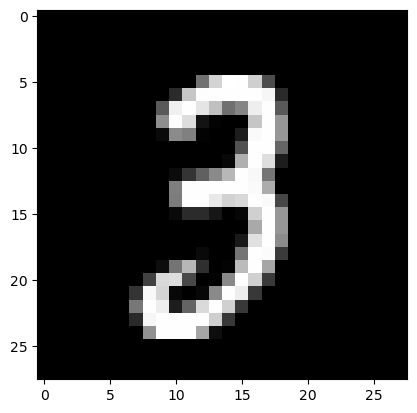

This is : 3


In [19]:
# Call the identify function to randomly select an image from the unseen dataset and make a prediction
identify()